# Solver comparison: Allen fit, whole-dataset, no noise


In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis


In [2]:
# dataset_meta = ['allen_B08']
dataset_meta = ['allen_A01']
dataset_names = [x for x in dataset_meta ]  
raw_data_locations = [x for x in dataset_meta]
transcriptome_filepath = './monod_demo_fits/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


In [3]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib.pyplot as plt
import scipy
def get_allen_meta(directory):
    allen_membership = pd.read_csv(directory+'/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
    allen_annot = pd.read_csv(directory+'/cluster.annotation.csv')
    allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
    allen_membership['sample'] = allen_membership['barcode'].str[-3:]
    allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
    allen_annot.set_index('cluster_id',inplace=True)
    allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
    meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
    return meta
meta_directory_v3 = '~/count_data/allen_metadata/sc'
meta_v3 = get_allen_meta(meta_directory_v3)


Dataset A01. 
	8145 barcodes in loom, 6443 pass filter. 6355 in annotations; of these, 6355 in loom and 5797 in filtered loom.


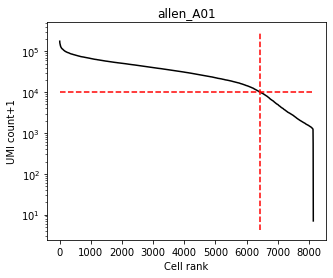

In [4]:
cf = []
thr_lb =  [1e4]
fig1,ax1 = plt.subplots(1,1,figsize=(5,4))

for k in range(len(dataset_meta)):
# for k in range(1):
    axloc = np.unravel_index(k,(2,4))
    filename = loom_filepaths[k ]
    dataset_name = raw_data_locations[k][-3:]
    
    meta = meta_v3
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        annot_bcs = meta[(meta['sample']==dataset_name)]['cell_barcode']
        cf.append(np.isin(bcs,annot_bcs) & cf_)

    ax1.set_title(raw_data_locations[k])


In [5]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [6]:
!mkdir -p monod_demo_fits

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1 already exists.
INFO:root:Dataset: allen_A01
INFO:root:5797 cells detected.
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:7355 genes retained after expression filter.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01 created.
INFO:root:Total of 200 genes selected.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1/diagnostic_figures created.


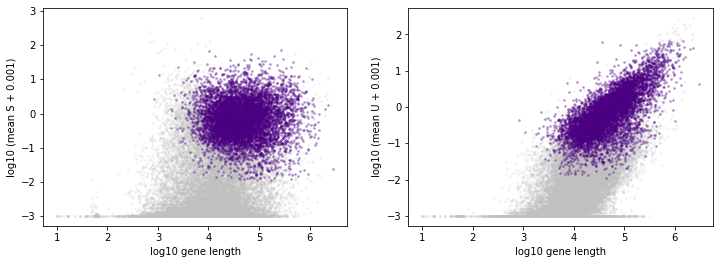

In [8]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./monod_demo_fits',meta='allen_noisefree',batch_id=1,\
                                             n_genes=200,exp_filter_threshold=None,cf=cf)


In [9]:
print(dir_string)
print(dataset_strings)

./monod_demo_fits/gg_230206_026_allen_noisefree_1
['./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01']


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_A01
INFO:root:32285 features observed, 32005 match genome annotations. 31649 were unique.
INFO:root:Gene list extracted from ./monod_demo_fits/gg_230206_026_allen_noisefree_1/genes.csv.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/diagnostic_figures already exists.
INFO:root:Search data stored to ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/raw.sd.
INFO:root:Search data loaded from ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/raw.sd.


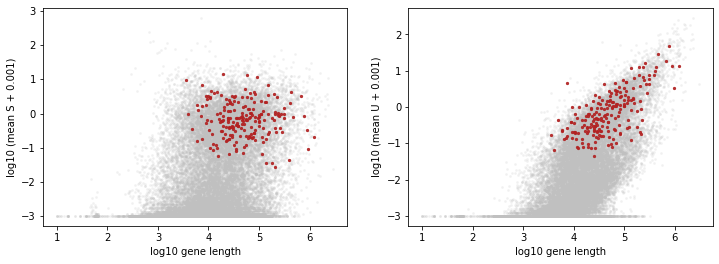

In [12]:
i = 0
_ = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
            dataset_strings[i], dir_string, dataset_attr_names=attribute_names,cf=cf[i])
search_data = monod.analysis.load_search_data(dataset_strings[0]+'/raw.sd')

In [13]:
result_strings = []
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
phys_lb = [-1.0, -1.8, -1.8 ]
phys_ub = [4.2, 2.5, 3.5]
samp_lb = [1,1]
samp_ub = [1,1]
gridsize = [1,1]

From the [previous notebook](https://github.com/pachterlab/GP_2021_3/blob/main/notebooks/noisefree_allen_fit.ipynb) running this dataset, we expect A01 to take a fairly short time.

In [14]:
i = 0
fitmodel = monod.cme_toolbox.CMEModel('Bursty','None')
inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
full_result_string = inference_parameters.fit_all_grid_points(1,search_data)
result_strings.append(full_result_string)



INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1 created.
INFO:root:Global inference parameters stored to ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/parameters.pr.
INFO:root:Starting non-parallelized grid scan.
INFO:root:Non-parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/analysis_figures created.
INFO:root:Runtime: 13.7 seconds.


In [15]:
full_result_string

'./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/grid_scan_results.res'

In [16]:
sr = monod.analysis.load_search_results(full_result_string)

INFO:root:Grid scan results loaded from ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/grid_scan_results.res.


In [17]:
# dataset_strings = ['./monod_demo_fits/gg_230206_025_allen_noisefree_1']
# search_data = monod.analysis.load_search_data(dataset_strings[0]+'/allen_B08/raw.sd')

In [68]:
i=0
fitmodel_qv = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='quad_vec')
inference_parameters_qv = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_qv,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})


INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1 already exists.
INFO:root:Global inference parameters stored to ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/parameters.pr.


slow!!!

In [18]:
i = 0
fitmodel_nn = monod.cme_toolbox.CMEModel('Bursty','None',quad_method='nn')
inference_parameters_nn = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
            dataset_strings[i],fitmodel_nn,use_lengths = False,
            gradient_params = {'max_iterations':15,'init_pattern':'moments','num_restarts':1})
nn_result_string = inference_parameters_nn.fit_all_grid_points(1,search_data)
result_strings.append(nn_result_string)

INFO:root:Sequencing model set to None. All sampling parameters set to null.
INFO:root:Directory ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1 already exists.
INFO:root:Global inference parameters stored to ./monod_demo_fits/gg_230206_026_allen_noisefree_1/allen_A01/Bursty_None_1x1/parameters.pr.
INFO:root:Starting non-parallelized grid scan.


KeyboardInterrupt: 

In [69]:
grad_inference = monod.inference.GradientInference(inference_parameters, fitmodel, search_data, 0)
grad_inference_qv = monod.inference.GradientInference(inference_parameters_qv, fitmodel_qv, search_data, 0)
grad_inference_nn = monod.inference.GradientInference(inference_parameters_nn, fitmodel_nn, search_data, 0)

In [70]:
import time

In [71]:
N=25

In [75]:
t = []
for i in range(N):
    t1 = time.time()
    grad_inference.optimize_gene(i,fitmodel,search_data)
    t.append(time.time()-t1)

In [76]:
t_qv = []
for i in range(N):
    t1 = time.time()
    grad_inference_qv.optimize_gene(i,fitmodel_qv,search_data)
    t_qv.append(time.time()-t1)

In [73]:
t_nn = []
for i in range(N):
    t1 = time.time()
    grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data)
    t_nn.append(time.time()-t1)  
    

In [77]:
t = np.asarray(t)
t_nn = np.asarray(t_nn)
t_qv = np.asarray(t_qv)

Text(0, 0.5, 'NN time')

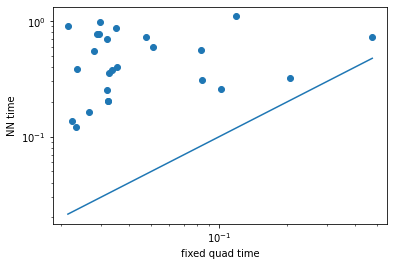

In [83]:
plt.scatter(t,t_nn)
xl = [t.min(),t.max()]
plt.plot(xl,xl)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('fixed quad time')
plt.ylabel('NN time')

Text(0, 0.5, 'NN time')

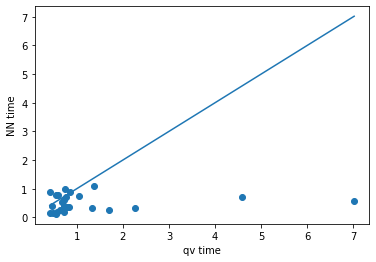

In [80]:
plt.scatter(t_qv,t_nn)
xl = [t_qv.min(),t_qv.max()]
plt.plot(xl,xl)
plt.xlabel('qv time')
plt.ylabel('NN time')

Text(0, 0.5, 'qv time')

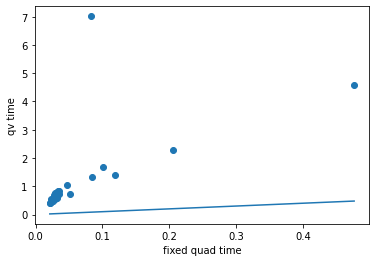

In [81]:
plt.scatter(t,t_qv)
xl = [t.min(),t.max()]
plt.plot(xl,xl)
plt.xlabel('fixed quad time')
plt.ylabel('qv time')

In [51]:
%load_ext line_profiler


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [66]:
%lprun -f monod.nn_toolbox.log_prob_1NB [grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data) for i in range(3)]

In [58]:
%lprun -f fitmodel_nn.eval_model_kld [grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data) for i in range(3)]

In [65]:
%lprun -f monod.nn_toolbox.get_ypred_log_1NB  [grad_inference_nn.optimize_gene(i,fitmodel_nn,search_data) for i in range(3)]